In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from keras_tuner import RandomSearch
import time

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape the images for MLP model (flatten them)
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28*28,)))  # Flatten input

    # Tune the number of hidden layers and units per layer
    for i in range(hp.Int('num_layers', 2, 5)):  # Between 2 and 5 hidden layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
                        activation='relu'))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperParameters

def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28*28,)))  # Flatten input

    # Tune the number of hidden layers and units per layer
    for i in range(hp.Int('num_layers', 2, 5)):  # Between 2 and 5 hidden layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
                        activation='relu'))

    # Output layer
    model.add(Dense(10, activation='softmax'))
    hp_batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)

    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Initialize Random Search with Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to be built and tested per trial
    directory='mnist_tuning',
    project_name='mlp_mnist'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Start timing
start_time = time.time()

# Search for best hyperparameters
tuner.search(x_train, y_train, epochs=50, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# End timing
end_time = time.time()
training_time = end_time - start_time
print(f"Training time for hyperparameter tuning: {training_time:.2f} seconds")

Trial 10 Complete [00h 14m 49s]
val_accuracy: 0.981249988079071

Best val_accuracy So Far: 0.9838333129882812
Total elapsed time: 02h 24m 01s
Training time for hyperparameter tuning: 8640.87 seconds


In [ ]:
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=best_hps.get('batch_size'))

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7331 - loss: 0.9560 - val_accuracy: 0.9413 - val_loss: 0.2055
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9445 - loss: 0.1911 - val_accuracy: 0.9591 - val_loss: 0.1421
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9637 - loss: 0.1277 - val_accuracy: 0.9634 - val_loss: 0.1292
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9721 - loss: 0.0975 - val_accuracy: 0.9661 - val_loss: 0.1102
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9772 - loss: 0.0773 - val_accuracy: 0.9714 - val_loss: 0.0961
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9838 - loss: 0.0559 - val_accuracy: 0.9677 - val_loss: 0.1033
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9864 - loss: 0.0458 - val_accuracy: 0.9740 - val_loss: 0.0888
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9901 - loss: 0.0338 - val

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

print(f"Test Accuracy of the tuned model: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9732 - loss: 0.1091
Test Accuracy of the tuned model: 0.9772


In [ ]:
print("Best Hyperparameters:")
print(f"Number of Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Units in Layer {i + 1}: {best_hps.get(f'units_{i}')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Batch Size: {best_hps.get('batch_size')}")

Best Hyperparameters:
Number of Layers: 4
Units in Layer 1: 448
Units in Layer 2: 384
Units in Layer 3: 448
Units in Layer 4: 256
Learning Rate: 0.0001
Batch Size: 96


In [ ]:
# Define a simple baseline model
baseline_model = Sequential([
    Flatten(input_shape=(28*28,)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the baseline model
baseline_model.fit(x_train, y_train, epochs=10, validation_split=0.2)

# Evaluate baseline model on test set
baseline_test_loss, baseline_test_accuracy = baseline_model.evaluate(x_test, y_test)

print(f"Baseline Test Accuracy: {baseline_test_accuracy:.4f}")

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8595 - loss: 0.4759 - val_accuracy: 0.9559 - val_loss: 0.1476
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9653 - loss: 0.1143 - val_accuracy: 0.9678 - val_loss: 0.1013
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9765 - loss: 0.0753 - val_accuracy: 0.9701 - val_loss: 0.0995
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9840 - loss: 0.0534 - val_accuracy: 0.9709 - val_loss: 0.0956
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9877 - loss: 0.0389 - val_accuracy: 0.9699 - val_loss: 0.1109
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9881 - loss: 0.0349 - val_accuracy: 0.9755 - val_loss: 0.0944
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9912 - loss: 0.0264 - val_accuracy: 0.9735 - val_loss: 0.1088
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9916 - loss: 0.024

In [ ]:
print(f"Final Test Accuracy of the Tuned MLP Model: {test_accuracy:.4f}")
print(f"Total Training Time for Hyperparameter Tuning: {training_time:.2f} seconds")

Final Test Accuracy of the Tuned MLP Model: 0.9772
Total Training Time for Hyperparameter Tuning: 8640.87 seconds


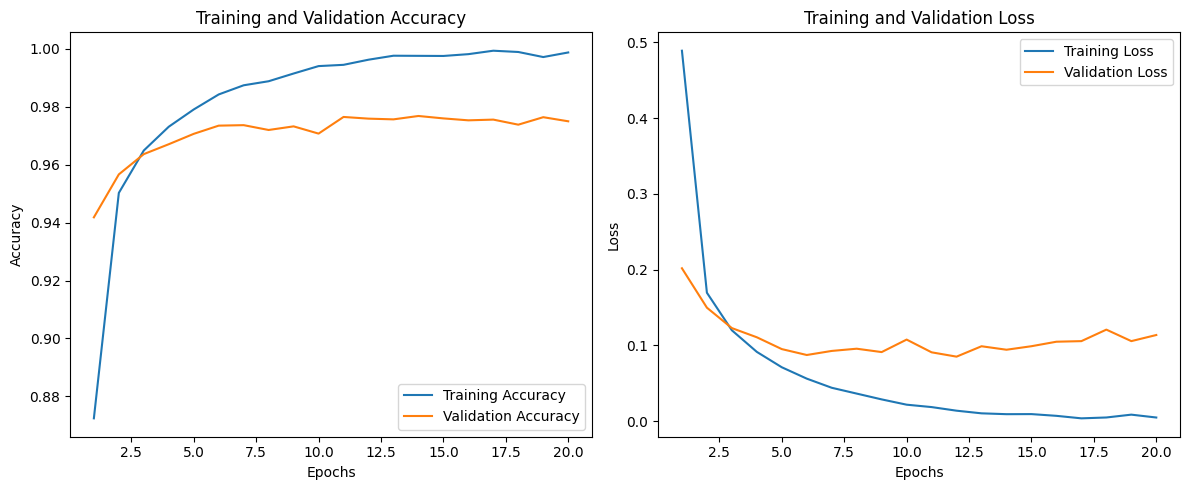

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Optimal Hyperparameters Selected:")
print(f"Number of Hidden Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Units in Hidden Layer {i + 1}: {best_hps.get(f'units_{i}')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Batch Size: {best_hps.get('batch_size')}")

Optimal Hyperparameters Selected:
Number of Hidden Layers: 4
Units in Hidden Layer 1: 448
Units in Hidden Layer 2: 384
Units in Hidden Layer 3: 448
Units in Hidden Layer 4: 256
Learning Rate: 0.0001
Batch Size: 96


In [ ]:
# Assuming the baseline model has already been trained and evaluated
print(f"Baseline Model Test Accuracy: {baseline_test_accuracy:.4f}")
print(f"Tuned MLP Model Test Accuracy: {test_accuracy:.4f}")

# Improvement in accuracy
accuracy_improvement = (test_accuracy - baseline_test_accuracy) * 100
print(f"Accuracy Improvement from Tuning: {accuracy_improvement:.2f}%")

Baseline Model Test Accuracy: 0.9775
Tuned MLP Model Test Accuracy: 0.9772
Accuracy Improvement from Tuning: -0.03%


In [ ]:
# Keras Tuner provides a summary
tuner.results_summary()

Results summary
Results in mnist_tuning/mlp_mnist
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
num_layers: 4
units_0: 448
units_1: 384
batch_size: 96
learning_rate: 0.0001
units_2: 448
units_3: 256
Score: 0.9838333129882812

Trial 00 summary
Hyperparameters:
num_layers: 2
units_0: 320
units_1: 448
batch_size: 128
learning_rate: 0.001
Score: 0.9820833206176758

Trial 08 summary
Hyperparameters:
num_layers: 2
units_0: 320
units_1: 448
batch_size: 128
learning_rate: 0.001
units_2: 512
units_3: 448
Score: 0.9816666841506958

Trial 07 summary
Hyperparameters:
num_layers: 3
units_0: 384
units_1: 448
batch_size: 32
learning_rate: 0.0001
units_2: 448
units_3: 512
Score: 0.9815833568572998

Trial 09 summary
Hyperparameters:
num_layers: 4
units_0: 128
units_1: 384
batch_size: 96
learning_rate: 0.0001
units_2: 448
units_3: 384
Score: 0.981249988079071

Trial 04 summary
Hyperparameters:
num_layers: 3
units_0: 384
units_1: 320
batch_size: